# OOR state detection simulation - highly variable gene selection analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np 
import milopy
import scipy
import warnings

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [6]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [7]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

## Preparation

In [8]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'

In [9]:
def _get_model_vars(model_dir):
    vars = sc.read(model_dir + '/adata.h5ad', backed=True).var
    return(vars)

In [60]:
## Make directories to save results
import shutil
# cts_oi = ['naive_B_cell', 'central_memory_CD4_positive_alpha_beta_T_cell','natural_killer_cell', 'classical_monocyte']
cts_oi = ['CD14_low_CD16_positive_monocyte', 'effector_memory_CD8_positive_alpha_beta_T_cell', 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell', 'memory_B_cell', 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell']
for ct in cts_oi:
    print(ct)
    simdir = outdir + f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'
    if not os.path.exists(simdir + 'HVG_comparison'):
        os.mkdir(simdir + 'HVG_comparison')
    # Copy trained models to new directory
    model_dirs = [f'{simdir}/{x}' for x in os.listdir(simdir) if x.startswith('model_')]
    for m in model_dirs:
        new_m = m.replace('/model_', '/HVG_comparison/model_5000HVG_')
        print(new_m)
        shutil.copytree(m, new_m, dirs_exist_ok=True)

CD14_low_CD16_positive_monocyte
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_ctrlquery
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_fit_query2atlas
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_fit_query2ctrl
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_atlas
/lustre/s

## Run OOR detection with fixed HVGs

```
echo "python compare_hvg_selection.py /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp//qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/ AR --embedding_method scArches --fixed_hvgs --hvg_data ctrlquery --milo_design ~is_query" | bsub -G teichlab -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M75000 -R "select[mem>75000] rusage[mem=75000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"

```


## Parse results

In [8]:
from oor_benchmark.metrics import FDR_TPR_FPR
from oor_benchmark.metrics import auprc
from oor_benchmark.methods.scArches_milo import run_milo

def harmonize_output(adata, signif_alpha=0.1):
    sample_adata = adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata.obsm["nhoods"].T
    adata.uns["sample_adata"] = sample_adata.copy()

def read_oor_design_output(simdir, ref_design, population_obs):
    perturb_pop = simdir.split(population_obs)[1].split('_seed')[0]
    print(f'Reading {perturb_pop}\n')
    h5ad_file = simdir + f'/{ref_design}_design.h5ad'
    adata = milopy.utils.read_milo_adata(
                h5ad_file, backed=False)
    adata.obs['OOR_state_name'] = perturb_pop
    return(adata)

def parse_design(adata, ref_design, hvg_data, emb_method):
    if 'sample_adata' not in adata.uns:
        harmonize_output(adata)
    perturb_pop = adata.obs['OOR_state_name'].unique()[0]
    tpr_df = FDR_TPR_FPR.FDR_TPR_FPR(adata)
    auprc_df = auprc.auprc(adata, return_curve=True)
    nhoods_df = adata.uns['sample_adata'].var.copy()
    tpr_df['design'] = ref_design
    tpr_df['OOR_state_name'] = perturb_pop
    tpr_df['emb_method'] = emb_method
    tpr_df['hvg_data'] = hvg_data
    auprc_df['design'] = ref_design
    auprc_df['OOR_state_name'] = perturb_pop
    auprc_df['emb_method'] = emb_method
    auprc_df['hvg_data'] = hvg_data
    nhoods_df['design'] = ref_design
    nhoods_df['OOR_state_name'] = perturb_pop
    nhoods_df['emb_method'] = emb_method
    nhoods_df['hvg_data'] = hvg_data
    return(nhoods_df, tpr_df, auprc_df)

Global seed set to 0


In [9]:
n_hvgs = 5000
emb_method = 'scVI'
hvg_data = 'atlas'
population_obs = 'cell_type'

def read_result(simdir,
    n_hvgs = 5000,
    population_obs = 'cell_type'
    ):
    nhoods_df_all = pd.DataFrame()
    tpr_df_all = pd.DataFrame()
    auprc_df_all = pd.DataFrame()
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    for n_hvgs in [2500, 5000, 10000]:
        for emb_method in ['scVI', 'scArches']:
            for d in ['ACR', "CR"]:
                if d == 'CR':
                    for hvg_data in ['atlas', 'new','ctrl', 'ctrlquery']:
                        if hvg_data == 'atlas':
                            h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'
                        else:
                            if n_hvgs == 5000:
                                h5ad_file = simdir + f'/{d}_design.{emb_method}_milo.h5ad'
                            else:
                                h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'    
                        try:
                            adata = milopy.utils.read_milo_adata(h5ad_file, backed=False)
                        except:
                            continue
                        adata.obs['OOR_state_name'] = perturb_pop
                        print(d, hvg_data, emb_method, n_hvgs)
                        nhoods_df, tpr_df, auprc_df = parse_design(adata, d, emb_method=emb_method, hvg_data=hvg_data)
                        nhoods_df['n_hvgs'] = n_hvgs
                        tpr_df['n_hvgs'] = n_hvgs
                        auprc_df['n_hvgs'] = n_hvgs
                        nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
                        tpr_df_all = pd.concat([tpr_df_all, tpr_df])
                        auprc_df_all = pd.concat([auprc_df_all, auprc_df])
                else:
                    hvg_data = 'new'
                    if n_hvgs == 5000:
                        h5ad_file = simdir + f'/{d}_design.{emb_method}_milo.h5ad'
                    else:
                        h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'
                    try:
                        adata = milopy.utils.read_milo_adata(h5ad_file, backed=False)
                    except:
                        continue
                    adata.obs['OOR_state_name'] = perturb_pop
                    print(d, hvg_data, emb_method, n_hvgs)
                    nhoods_df, tpr_df, auprc_df = parse_design(adata, d, emb_method=emb_method, hvg_data=hvg_data)
                    nhoods_df['n_hvgs'] = n_hvgs
                    tpr_df['n_hvgs'] = n_hvgs
                    auprc_df['n_hvgs'] = n_hvgs
                    nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
                    tpr_df_all = pd.concat([tpr_df_all, tpr_df])
                    auprc_df_all = pd.concat([auprc_df_all, auprc_df])

    # print(auprc_df_all.head())
    nhoods_df_all.to_csv(simdir + f'/HVG_comparison/nhoods_obs.csv')
    tpr_df_all.to_csv(simdir + f'/HVG_comparison/TPR_res.csv')
    auprc_df_all.to_csv(simdir + f'/HVG_comparison/AUPRC_res.csv')

## Is HVG selection determining difference btw integration strategies in CR design?

In [10]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
cts_oi = ['naive_B_cell', 'central_memory_CD4_positive_alpha_beta_T_cell','natural_killer_cell', 'classical_monocyte',
          'CD14_low_CD16_positive_monocyte', 'effector_memory_CD8_positive_alpha_beta_T_cell', 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell', 'memory_B_cell','naive_thymus_derived_CD8_positive_alpha_beta_T_cell'
         ]
simdirs = [outdir + f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022' for ct in cts_oi]

In [11]:
simdirs

['/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeclassical_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022',
 '/lustre/scratch117

In [13]:
nhoods_df_all = pd.DataFrame()
tpr_df_all = pd.DataFrame()
auprc_df_all = pd.DataFrame()

population_obs = 'cell_type'
n_hvgs = 5000
params = (
    ("CR", 'scVI', 'ctrl'),
    ("CR", 'scVI', 'new'),
    ("CR", 'scVI', 'atlas'),
    ("CR", 'scArches', 'new'),
    ("CR", 'scArches', 'ctrlquery'),
    ("CR", 'scArches', 'atlas'),
    ("ACR", 'scArches', 'new'),
    ("ACR", 'scArches', 'ctrl'),
    ("ACR", 'scArches', 'ctrlquery')
)

for simdir in simdirs:
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    for p in params:
        d, emb_method, hvg_data = p
        if hvg_data == 'new':
            h5ad_file = simdir + f'/{d}_design.{emb_method}_milo.h5ad'
        else:
            h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'
#         try:
        adata1 = milopy.utils.read_milo_adata(h5ad_file, backed=True)
#         except:
#             print(f'Skipping {d} {emb_method} {hvg_data}')
#             continue
        adata1.obs['OOR_state_name'] = perturb_pop
        adata1.uns['nhood_adata'] = adata1.uns['nhood_adata'].to_memory()
        nhoods_df, tpr_df, auprc_df = parse_design(adata1, d, emb_method=emb_method, hvg_data=hvg_data)
        nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
        tpr_df_all = pd.concat([tpr_df_all, tpr_df])
        auprc_df_all = pd.concat([auprc_df_all, auprc_df])

In [ ]:
%%R -i auprc_df_all
head(auprc_df_all)

  Recall  Precision   AUPRC no_skill_thresh design OOR_state_name emb_method
1      1 0.06314700 0.42068        0.063147     CR   naive_B_cell       scVI
2      1 0.06321244 0.42068        0.063147     CR   naive_B_cell       scVI
3      1 0.06327801 0.42068        0.063147     CR   naive_B_cell       scVI
4      1 0.06334372 0.42068        0.063147     CR   naive_B_cell       scVI
5      1 0.06340956 0.42068        0.063147     CR   naive_B_cell       scVI
6      1 0.06347555 0.42068        0.063147     CR   naive_B_cell       scVI
  hvg_data
1     ctrl
2     ctrl
3     ctrl
4     ctrl
5     ctrl
6     ctrl


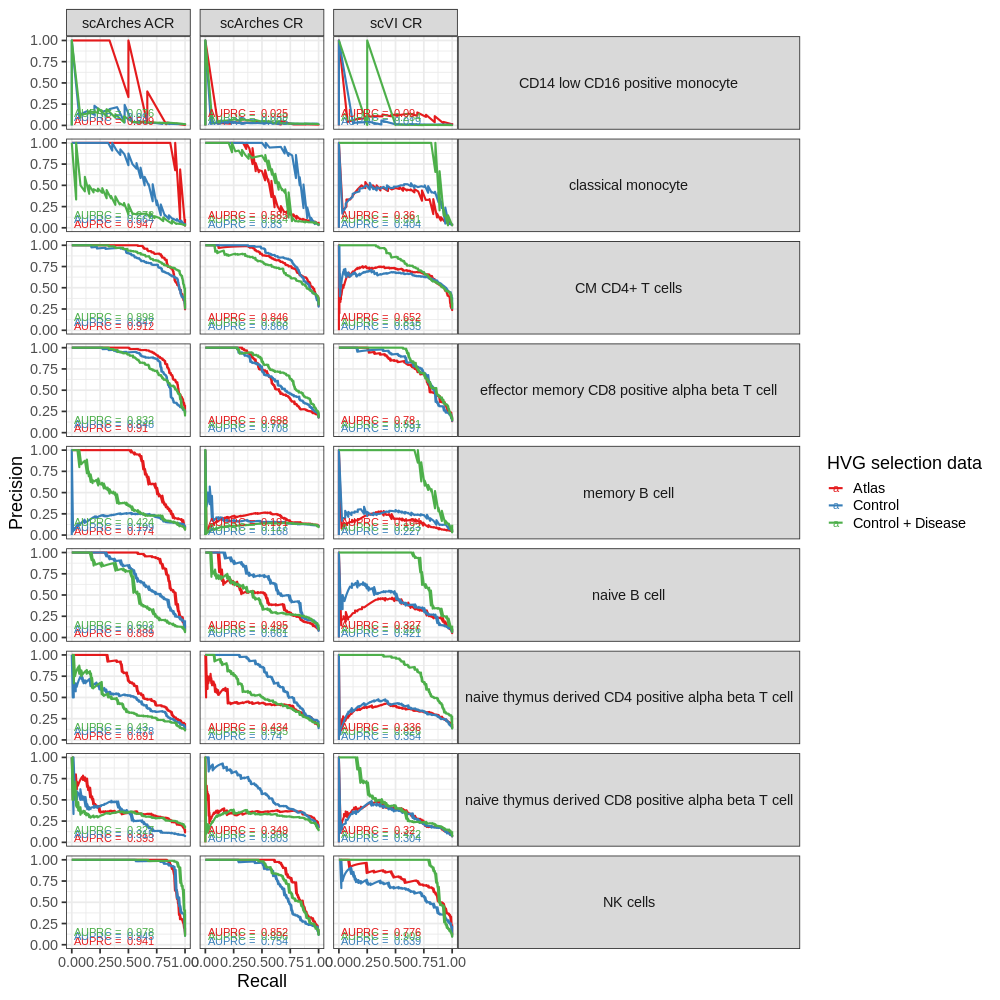

In [ ]:
%%R -w 1000 -h 1000
rename_hvg_data <- c(
    'ctrl' = 'Control',
    'ctrlquery' = 'Control + Disease',
    'atlas' = 'Atlas'
)

auprc_df_all %>%
mutate(g = paste(emb_method, design)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'CR', 'ctrl', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'ACR', 'atlas', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scVI' & hvg_data == 'new', 'ctrlquery', hvg_data)) %>%
mutate(hvg_data = rename_hvg_data[hvg_data]) %>%
mutate(OOR_state_name = str_replace_all(OOR_state_name, "_", ' ')) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "central memory CD4 positive alpha beta T cell", 'CM CD4+ T cells', OOR_state_name)) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "natural killer cell", 'NK cells', OOR_state_name)) %>%
ggplot(aes(Recall, Precision, color=hvg_data))+
geom_line(size=1) +
geom_text(data=. %>% distinct(AUPRC, hvg_data, OOR_state_name, g, hvg_data) %>% group_by(OOR_state_name, g) %>% mutate(id = row_number()), 
          aes(label=paste('AUPRC = ',round(AUPRC, 3)), y=id*0.05), x=0.02, hjust=0) +
# geom_hline(aes(yintercept=no_skill_thresh), linetype=2) +
facet_grid(OOR_state_name~g) +
scale_color_brewer(palette='Set1', name='HVG selection data') +
theme_bw(base_size=18) +
theme(strip.text.y=element_text(angle=0)) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_PR_curves.pdf', height=15, width=16) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_PR_curves.png', height=15, width=16) 


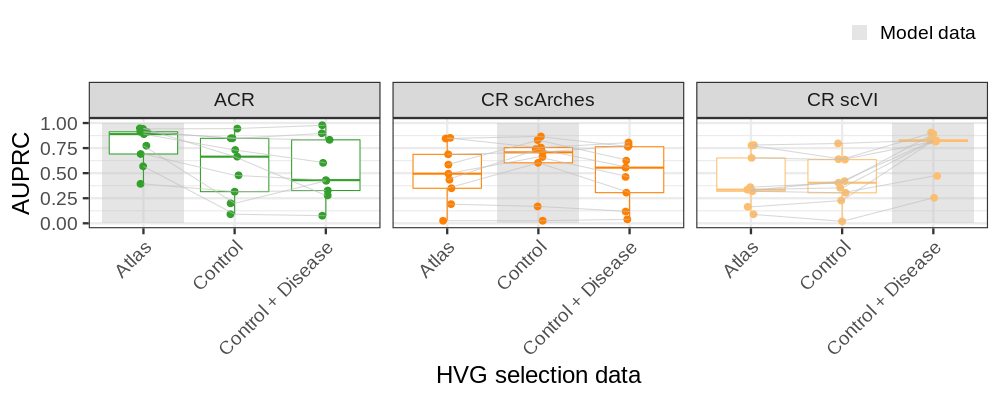

In [40]:
%%R -w 1000 -h 400
rename_hvg_data <- c(
    'ctrl' = 'Control',
    'ctrlquery' = 'Control + Disease',
    'atlas' = 'Atlas'
)

auprc_df_all %>%
mutate(g = ifelse(design == 'CR', paste(design, emb_method), design)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'CR', 'ctrl', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'ACR', 'atlas', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scVI' & hvg_data == 'new', 'ctrlquery', hvg_data)) %>%
mutate(hvg_data = rename_hvg_data[hvg_data]) %>%
mutate(OOR_state_name = str_replace_all(OOR_state_name, "_", ' ')) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "central memory CD4 positive alpha beta T cell", 'CM CD4+ T cells', OOR_state_name)) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "natural killer cell", 'NK cells', OOR_state_name)) %>%
mutate(model_data = ifelse(g == 'ACR', 'Atlas', ifelse(g == "CR scArches", 'Control', 'Control + Disease'))) %>%
distinct(OOR_state_name,g, AUPRC, hvg_data, no_skill_thresh, design, model_data) %>%
rename(`HVG selection data` = hvg_data) %>%
ggplot(aes(`HVG selection data`, AUPRC, color=g)) +
geom_col(data=. %>% distinct(model_data, g), aes(model_data, y=1, fill='Model data'), color=NA,  position='identity', alpha=0.4) +
geom_boxplot(outlier.alpha=0) +
geom_jitter(size=3, width=0.05) +
geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
theme_bw(base_size=24) +
facet_grid(.~g) +
scale_color_manual(values=design_palette, name='design') +
scale_fill_manual(values=c('Model data'='grey'), name='') +
# xlab('design') +
guides(color='none') +
theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1),
      legend.position='top', legend.justification=c(1,1)
     ) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_AUPRC.pdf', height=6, width=10) +
ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_AUPRC.png', height=6, width=10) 


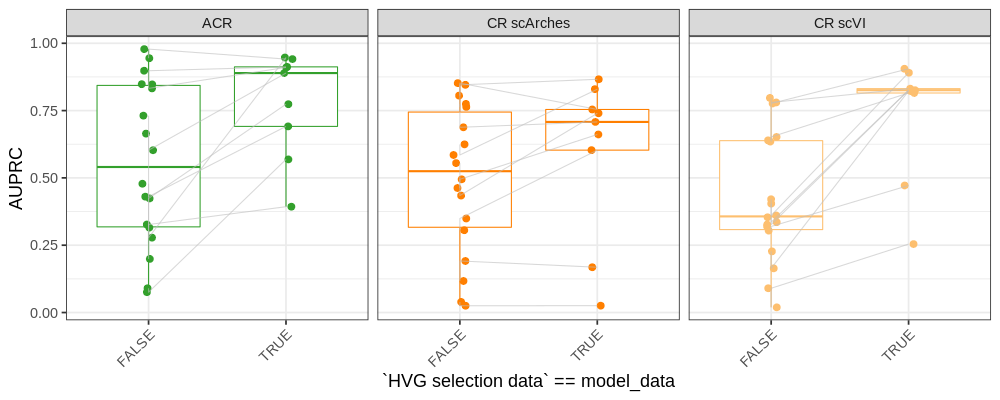

In [29]:
%%R -w 1000 -h 400
rename_hvg_data <- c(
    'ctrl' = 'Control',
    'ctrlquery' = 'Control + Disease',
    'atlas' = 'Atlas'
)

auprc_df_all %>%
mutate(g = ifelse(design == 'CR', paste(design, emb_method), design)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'CR', 'ctrl', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'ACR', 'atlas', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scVI' & hvg_data == 'new', 'ctrlquery', hvg_data)) %>%
mutate(hvg_data = rename_hvg_data[hvg_data]) %>%
mutate(OOR_state_name = str_replace_all(OOR_state_name, "_", ' ')) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "central memory CD4 positive alpha beta T cell", 'CM CD4+ T cells', OOR_state_name)) %>%
mutate(OOR_state_name = ifelse(OOR_state_name == "natural killer cell", 'NK cells', OOR_state_name)) %>%
mutate(model_data = ifelse(g == 'ACR', 'Atlas', ifelse(g == "CR scArches", 'Control', 'Control + Disease'))) %>%
distinct(OOR_state_name,g, AUPRC, hvg_data, no_skill_thresh, design, model_data) %>%
rename(`HVG selection data` = hvg_data) %>%
ggplot(aes(`HVG selection data` == model_data, AUPRC, color=g)) +
# geom_col(data=. %>% distinct(model_data, g), aes(model_data, y=1, fill='Model data'), color=NA,  position='identity', alpha=0.5) +
geom_boxplot(outlier.alpha=0) +
geom_jitter(size=3, width=0.05) +
geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
theme_bw(base_size=24) +
facet_grid(.~g) +
scale_color_manual(values=design_palette, name='design') +
scale_fill_manual(values=c('Model data'='grey'), name='') +
# xlab('design') +
theme_bw(base_size=18) +
guides(color='none') +
theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) 
# ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_AUPRC.pdf', height=6, width=12) +
# ggsave('/home/jovyan/mount/gdrive/diff2atlas/figures/HVG_data_AUPRC.png', height=6, width=12) 


In [18]:
## Save results for HVG variation analysis
tpr_df_all.to_csv(f'{outdir}/HVG_comparison.5000HVG.TPR_results.csv')
auprc_df_all.to_csv(f'{outdir}/HVG_comparison.5000HVG.AUPRC_results.csv')

In [35]:
def _get_model_vars(model_dir):
    vars = sc.read(model_dir + '/adata.h5ad', backed=True).var
    return(vars)

n_hvgs = 5000
n_intersect_df = pd.DataFrame(columns=['ctrl_vs_ctrlquery', 'atlas_vs_ctrlquery', 'atlas_vs_ctrl'])
for simdir in simdirs:
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    vars_ctrl = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_ctrl').index
    vars_ctrlquery = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_ctrlquery').index
    vars_atlas = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_atlas').index
    n_intersect_df.loc[perturb_pop, 'ctrl_vs_ctrlquery'] = np.intersect1d(vars_ctrlquery, vars_ctrl).shape[0]
    n_intersect_df.loc[perturb_pop, 'atlas_vs_ctrlquery'] = np.intersect1d(vars_atlas, vars_ctrlquery).shape[0]
    n_intersect_df.loc[perturb_pop, 'atlas_vs_ctrl'] = np.intersect1d(vars_atlas, vars_ctrl).shape[0]
        

In [36]:
n_intersect_df

,ctrl_vs_ctrlquery,atlas_vs_ctrlquery,atlas_vs_ctrl
naive_B_cell,4077,3393,3254
central_memory_CD4_positive_alpha_beta_T_cell,3892,3320,3102
natural_killer_cell,4043,3481,3354
classical_monocyte,4041,3394,3252
CD14_low_CD16_positive_monocyte,4088,3397,3221
effector_memory_CD8_positive_alpha_beta_T_cell,4069,3433,3263
naive_thymus_derived_CD4_positive_alpha_beta_T_cell,4057,3431,3258
memory_B_cell,4089,3420,3250
naive_thymus_derived_CD8_positive_alpha_beta_T_cell,4085,3409,3254


In [37]:
n_intersect_df.to_csv(f'{outdir}/HVG_comparison.5000HVG.Nintersect_results.csv')

In [17]:
n_intersect_df = pd.read_csv(f'{outdir}/HVG_comparison.5000HVG.Nintersect_results.csv', index_col=0)
(n_intersect_df).mean()

ctrl_vs_ctrlquery     4049.000000
atlas_vs_ctrlquery    3408.666667
atlas_vs_ctrl         3245.333333
dtype: float64